# Importing the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import time
from datetime import date

from sklearn.linear_model import LogisticRegression 
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import OneHotEncoder 
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn import neighbors
from imblearn.over_sampling import SMOTE 

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# Cleaning and preparing the data

In [8]:
customer_churn = pd.read_csv('customer_churn.csv')

In [9]:
# Keeping only those variables (columns) identified in the lab instructions:

customer_churn_vars = customer_churn[['tenure', 'SeniorCitizen', 'MonthlyCharges', 'Churn']]

In [10]:
# No NaNs or duplicates to remove in the data set. 
# It looks like SeniorCitizen should be categorical (yes/no) so we need to change it to an object

print(sum(customer_churn.duplicated()))
print(customer_churn_vars.shape)
print(customer_churn_vars.info())
customer_churn_vars.head()

0
(7043, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tenure          7043 non-null   int64  
 1   SeniorCitizen   7043 non-null   int64  
 2   MonthlyCharges  7043 non-null   float64
 3   Churn           7043 non-null   object 
dtypes: float64(1), int64(2), object(1)
memory usage: 220.2+ KB
None


,tenure,SeniorCitizen,MonthlyCharges,Churn
0,1,0,29.85,No
1,34,0,56.95,No
2,2,0,53.85,Yes
3,45,0,42.30,No
4,2,0,70.70,Yes


In [11]:
# Convert SeniorCitizen to a categorical variable (str)

def boolean(x):
    if x==1:
        return 'yes'
    else:
        return 'no'

customer_churn_vars['SeniorCitizen'] = list(map(boolean,customer_churn_vars['SeniorCitizen']))

/var/folders/kp/1thpb47s3s540gy9cm49qr740000gn/T/ipykernel_35214/2178104947.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_churn_vars['SeniorCitizen'] = list(map(boolean,customer_churn_vars['SeniorCitizen']))


In [12]:
# Convert Churn into a 0 / 1 binary

def boolean2(x):
    if x=='Yes':
        return 1
    else:
        return 0

customer_churn_vars['Churn'] = list(map(boolean2,customer_churn_vars['Churn']))

customer_churn_vars

/var/folders/kp/1thpb47s3s540gy9cm49qr740000gn/T/ipykernel_35214/97344199.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_churn_vars['Churn'] = list(map(boolean2,customer_churn_vars['Churn']))


,tenure,SeniorCitizen,MonthlyCharges,Churn
0,1,no,29.85,0
1,34,no,56.95,0
2,2,no,53.85,1
3,45,no,42.30,0
4,2,no,70.70,1
...,...,...,...,...
7038,24,no,84.80,0
7039,72,no,103.20,0
7040,11,no,29.60,0
7041,4,yes,74.40,1


In [132]:
# Only two numerical categories, which we can normalize once we split the data

customer_churn_vars.describe().T

,count,mean,std,min,25%,50%,75%,max
tenure,7043.0,32.371149,24.559481,0.00,9.0,29.00,55.00,72.00
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75
Churn,7043.0,0.000000,0.000000,0.00,0.0,0.00,0.00,0.00


# Preparing and testing the model

In [13]:
# Now that we have the final dataset for train/test, we can do the split and train our model data

y = customer_churn_vars['Churn']
X = customer_churn_vars.drop(['Churn'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

In [14]:
# Using standard scaler on numericals this time because the ranges are not extreme and (only two variables)

X_train_num = X_train.select_dtypes(include = np.number)
X_test_num = X_test.select_dtypes(include = np.number)

transformer = StandardScaler().fit(X_train_num)
X_train_scaled = pd.DataFrame(transformer.transform(X_train_num),columns=X_test_num.columns)
X_test_scaled = pd.DataFrame(transformer.transform(X_test_num),columns=X_test_num.columns) # Also for test data using same transformer

X_train_scaled

,tenure,MonthlyCharges
0,0.763377,0.692959
1,-1.028039,0.971264
2,0.437665,0.516310
3,-0.010189,-0.948539
4,-1.028039,0.391323
...,...,...
5629,-0.050903,-0.345268
5630,-1.272323,-0.321937
5631,-0.498757,-0.183618
5632,1.618371,1.677858


In [15]:
# Reset indexes so we can concatenate later

y_train = y_train.reset_index(drop=True) 
y_test = y_test.reset_index(drop=True) 

In [16]:
# Getting dummies for the categoricals on training data...

X_train_cat = X_train.select_dtypes(include = object)

encoder = OneHotEncoder(drop='first').fit(X_train_cat)
encoded = encoder.transform(X_train_cat).toarray()

cols = encoder.get_feature_names_out(input_features=X_train_cat.columns)

X_train_cat = pd.DataFrame(encoded, columns=cols)
X_train_cat

,SeniorCitizen_yes
0,0.0
1,0.0
2,0.0
3,0.0
4,1.0
...,...
5629,0.0
5630,0.0
5631,0.0
5632,0.0


In [17]:
# ... and for test data categoricals

X_test_cat = X_test.select_dtypes(include = object)

encoder2 = OneHotEncoder(drop='first').fit(X_test_cat)
encoded2 = encoder2.transform(X_test_cat).toarray()

cols2 = encoder2.get_feature_names_out(input_features=X_test_cat.columns)

X_test_cat = pd.DataFrame(encoded2, columns=cols2)
X_test_cat

,SeniorCitizen_yes
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
1404,0.0
1405,0.0
1406,0.0
1407,0.0


In [18]:
X_train_transformed = np.concatenate([X_train_scaled, X_train_cat], axis=1)

In [19]:
X_test_transformed = np.concatenate([X_test_scaled, X_test_cat], axis=1)

In [20]:
classification = LogisticRegression(random_state=69, solver='lbfgs',
                  multi_class='multinomial').fit(X_train_transformed, y_train)

In [21]:
# I'm not sure how / why this code is different from that below, but the scores are not exactly aligned.

predictions = classification.predict(X_test_transformed)
classification.score(X_test_transformed, y_test)

0.7963094393186657

In [22]:
LR = LogisticRegression(random_state=69, solver='lbfgs')
LR.fit(X_train_scaled, y_train)
LR.score(X_test_scaled, y_test)

0.7828246983676366

In [23]:
pred = LR.predict(X_test_scaled) 

print("precision: ",precision_score(y_test,pred))
print("recall: ",recall_score(y_test,pred))
print("f1: ",f1_score(y_test,pred))

precision:  0.6023622047244095
recall:  0.4273743016759777
f1:  0.5


In [24]:
confusion_matrix(y_test,pred)

array([[950, 101],
       [205, 153]])

# Resampling and re-testing the model

0    1051
1     358
Name: Churn, dtype: int64


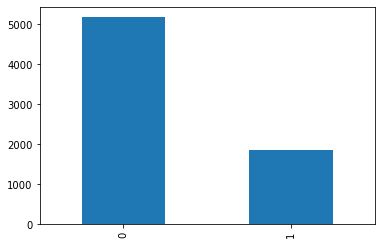

In [25]:
# We see a data imbalance and our original model score is not great @ around 0.78

count_classes = customer_churn_vars['Churn'].value_counts()
count_classes
count_classes.plot(kind = 'bar')
print(y_test.value_counts())

# Trying oversampling first

In [26]:
# Reassemble the training data

train = pd.concat([X_train_scaled, y_train],axis=1)

In [27]:
# Separate majority/minority classes in the target

no_churn = train[train['Churn']==0]
yes_churn = train[train['Churn']==1]

In [28]:
yes_churn_oversampled = resample(yes_churn, 
                                    replace=True,
                                    n_samples = len(no_churn),
                                    random_state=0)

In [29]:
train_oversampled = pd.concat([no_churn,yes_churn_oversampled],axis=0)

In [30]:
y_train_over = train_oversampled['Churn'].copy()
X_train_over = train_oversampled.drop('Churn', axis = 1).copy()

In [31]:
# This result is not much better than the imbalanced sample...

LR_over = LogisticRegression(random_state=69, solver='lbfgs')
LR_over.fit(X_train_over, y_train_over)
pred_over = LR_over.predict(X_test_scaled)

print("precision: ",precision_score(y_test,pred))
print("recall: ",recall_score(y_test,pred))
print("f1: ",f1_score(y_test,pred))

confusion_matrix(y_test,pred)

precision:  0.6023622047244095
recall:  0.4273743016759777
f1:  0.5


array([[950, 101],
       [205, 153]])

# Trying undersampling

In [34]:
no_churn_undersampled = resample(no_churn, 
                                    replace=False,
                                    n_samples = len(yes_churn),
                                    random_state=0)

In [35]:
train_undersampled = pd.concat([yes_churn,no_churn_undersampled], axis=0)

In [36]:
y_train_under = train_undersampled['Churn'].copy()
X_train_under = train_undersampled.drop('Churn',axis = 1).copy()

In [40]:
# Recall is better this time so we are optimizing for false negatives with the undersample.

LR_under = LogisticRegression(random_state=0, solver='lbfgs')
LR_under.fit(X_train_under, y_train_under)
pred = LR_under.predict(X_test_scaled)

print("precision: ",precision_score(y_test,pred))
print("recall: ",recall_score(y_test,pred))
print("f1: ",f1_score(y_test,pred))

confusion_matrix(y_test,pred)

precision:  0.488245931283906
recall:  0.7541899441340782
f1:  0.5927552140504939


array([[768, 283],
       [ 88, 270]])

# SMOTE

In [38]:
sm = SMOTE(random_state=69, k_neighbors=3)
X_train_SMOTE,y_train_SMOTE = sm.fit_resample(X_train_scaled,y_train)

In [41]:
# SMOTE nearest neighbors approach does not give much better results than the undersample so it's a toss up. 

LR_SMOTE = LogisticRegression(random_state=69, solver='lbfgs')
LR_SMOTE.fit(X_train_SMOTE, y_train_SMOTE)
pred = LR_SMOTE.predict(X_test_scaled)

print("precision: ",precision_score(y_test,pred))
print("recall: ",recall_score(y_test,pred))
print("f1: ",f1_score(y_test,pred))

confusion_matrix(y_test,pred)

precision:  0.49005424954792043
recall:  0.7569832402234636
f1:  0.5949506037321625


array([[769, 282],
       [ 87, 271]])